NASA Jet Fan Engine Remaining Usable Life(RUL)

In [207]:
# %%

%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, MinMaxScaler,StandardScaler
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)





In [191]:
# Load data
FD001_data = pd.read_csv('CMAPSSData/train_FD001.txt',delim_whitespace=True)
pd.set_option('display.max_rows', None)

#FD001_data.info()

# List of sensor names
sensor_names =['Fan inlet temperature ◦R', 'LPC outlet temperature ◦R', 
'HPC outlet temperature ◦R', 'LPT outlet temperature ◦R',
'Fan inlet Pressure psia', 'bypass-duct pressure psia',
'HPC outlet pressure psia', 'Physical fan speed rpm',
'Physical core speed rpm', 'Engine pressure ratioP50/P2',
'HPC outlet Static pressure psia', 'Ratio of fuel flow to Ps30 pps/psia',
'Corrected fan speed rpm', 'Corrected core speed rpm', 'Bypass Ratio ', 
'Burner fuel-air ratio', 'Bleed Enthalpy', 'Required fan speed', 
'Required fan conversion speed', 'High-pressure turbines Cool air flow', 
'Low-pressure turbines Cool air flow']

#Setting dict to store new names for colummns 
operational_dict = {
    '1':'Engine',
    '1.1':'Cycles',
    '-0.0007': 'Operational Setting 1',
    '-0.0004': 'Operational Setting 2',
    '100.0': 'Operational Setting 3',
}

#Creating a list of columns names
old_columns = list(FD001_data.columns)

#Removing column names found in operational_dict
operational_columns_to_rename = [col for col in old_columns if col not in operational_dict.keys()]

#Combining the two lists into a dict using tuple type casting
converged_names = dict(map(lambda i,j : (i,j) , operational_columns_to_rename,sensor_names))

# Combine both dictionaries (operational_dict and converged_names) ** is just short hand combining of the dictionary
all_rename_dict = {**operational_dict, **converged_names}

# Renaming columns in the dataframe
FD001_data.rename(columns=all_rename_dict, inplace=True)
print(FD001_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20630 entries, 0 to 20629
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Engine                                20630 non-null  int64  
 1   Cycles                                20630 non-null  int64  
 2   Operational Setting 1                 20630 non-null  float64
 3   Operational Setting 2                 20630 non-null  float64
 4   Operational Setting 3                 20630 non-null  float64
 5   Fan inlet temperature ◦R              20630 non-null  float64
 6   LPC outlet temperature ◦R             20630 non-null  float64
 7   HPC outlet temperature ◦R             20630 non-null  float64
 8   LPT outlet temperature ◦R             20630 non-null  float64
 9   Fan inlet Pressure psia               20630 non-null  float64
 10  bypass-duct pressure psia             20630 non-null  float64
 11  HPC outlet pres

Skewness of Fan inlet temperature ◦R: 0.0
Skewness of LPC outlet temperature ◦R: 0.316583501137655
Skewness of HPC outlet temperature ◦R: 0.3089193176181448
Skewness of LPT outlet temperature ◦R: 0.4431150548728743
Skewness of Fan inlet Pressure psia: 0.0
Skewness of bypass-duct pressure psia: -6.916635002907901
Skewness of HPC outlet pressure psia: -0.3942606916976628
Skewness of Physical fan speed rpm: 0.47934011995066556
Skewness of Physical core speed rpm: 2.5553469250442564
Skewness of Engine pressure ratioP50/P2: 0.0
Skewness of HPC outlet Static pressure psia: 0.4692823094660817
Skewness of Ratio of fuel flow to Ps30 pps/psia: -0.4423533166145076
Skewness of Corrected fan speed rpm: 0.46972290073323913
Skewness of Corrected core speed rpm: 2.3724704578719185
Skewness of Bypass Ratio : 0.3881823266382687
Skewness of Burner fuel-air ratio: 0.0
Skewness of Bleed Enthalpy: 0.35304226645162856
Skewness of Required fan speed: 0.0
Skewness of Required fan conversion speed: 0.0
Skewness

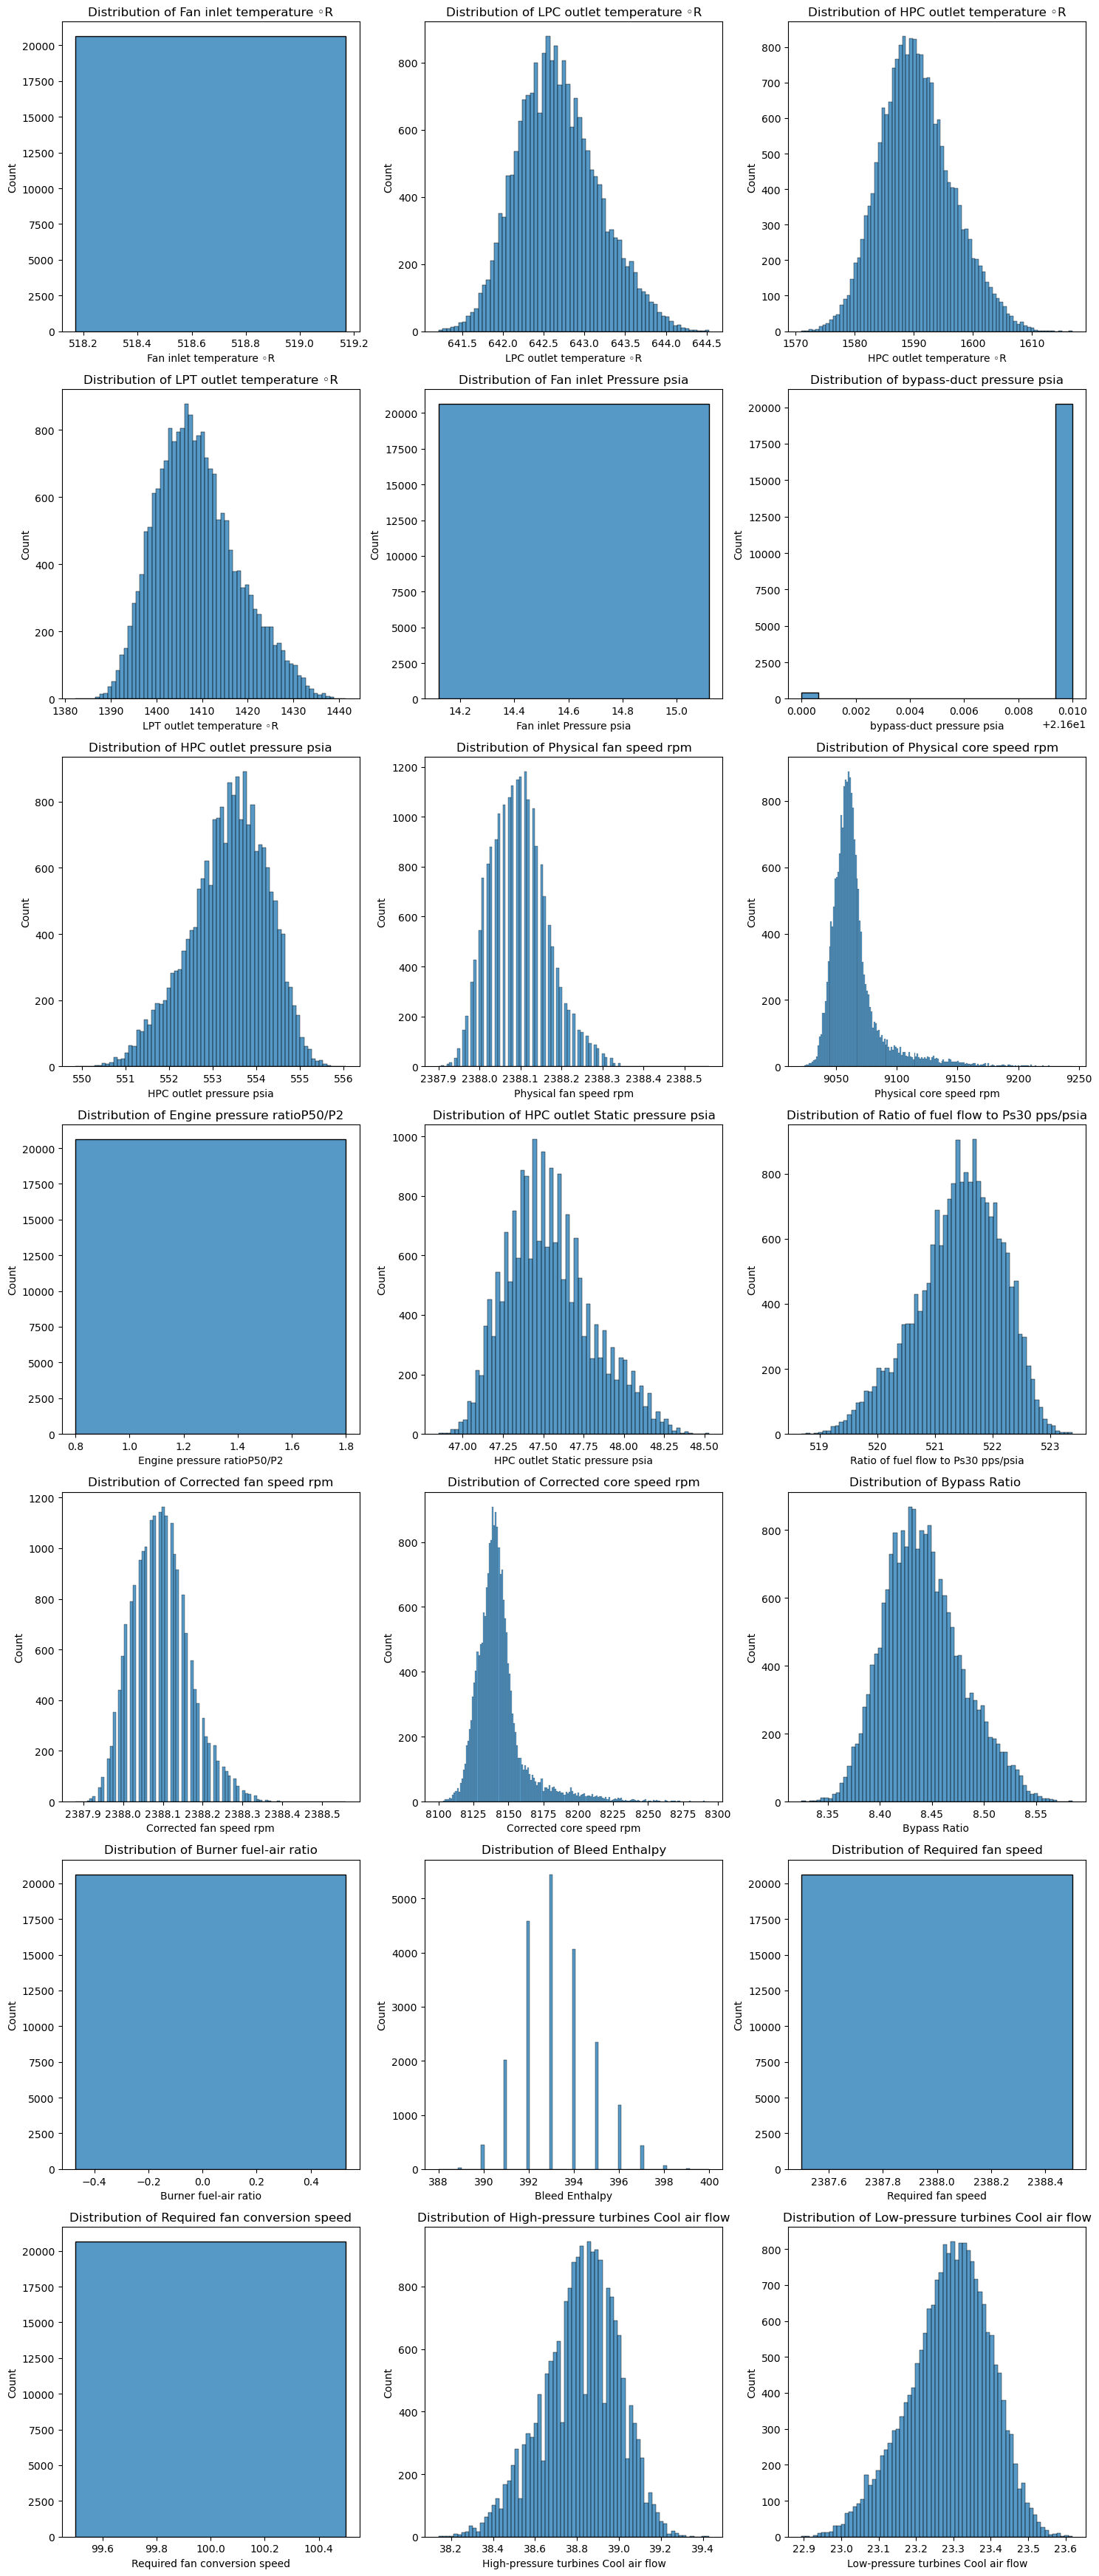

Columns that need normalization: ['bypass-duct pressure psia', 'Physical core speed rpm', 'Corrected core speed rpm']


In [192]:
columns_to_normalize = []

# Determine the number of rows and columns for the subplot grid
num_columns = len([col for col in FD001_data.columns if col in sensor_names])
num_rows = int(np.ceil(num_columns / 3)) #Making columns

# Create subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))  
axes = axes.flatten()  # Flatten to easily iterate over it

# Loop through each column and create an individual plot (only sensor names)
for i, column in enumerate(FD001_data[sensor_names]):
    if column in sensor_names:
        sns.histplot(data=FD001_data[column], ax=axes[i])
        axes[i].set_title(f'Distribution of {column}')
        skewness = FD001_data[column].skew()
        print(f'Skewness of {column}: {skewness}')
        
        # Check if the skewness is outside the range of -0.5 to 0.5
        if skewness < -0.5 or skewness > 0.5:
            columns_to_normalize.append(column)

# Hide any unused subplots if there are any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Print the columns that need normalization
print(f'Columns that need normalization: {columns_to_normalize}')


The Data is mostly gaussian and predictable. In the time series application, I was able to decompose all the sensor data and determine residuls, QQplot. The data can be found timeSeries_explore.ipynb. 

I decided not to normalize the 'Physical core speed rpm', and
'Corrected core speed rpm' due to the scores and residuals of the time series decompostion and prediction square difference. Also this data is modeled to reflect real-world scenarios and at this time I'm deciding to not normalize these two features even though there are indications of skewness. 

I will treat this excercise in terms that I'm familiar with. In computer scinece we have ways of evaluating the health of computer components and software. Each component of a system has health metrics that indicate stress, load, deterioration and so-on. Although I'm not a domain expert in jet engines I will try and assume that the coponents of a jet fan engine have the same indicators though some meaningful modles that we can use to understand the health of that component.

Modern jet engines generally operate at 40 to 55:1 at sea level.(Our test case).Generally speaking, higher overall pressure ratio implies higher efficiency. The disadvantage to higher efficiency is heat. As air travels through the compressor, it reaches temps that could cause the deterioration of the compressor blades. This is especially true for the last compressor stage(Wikipedia.org). 

The workflow for the jet fan engine is as follows:

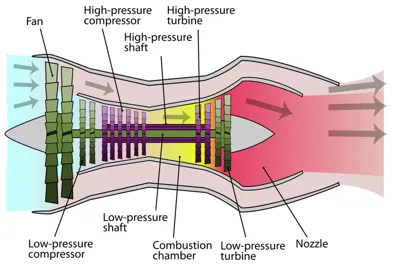






In [193]:
# Defining the HPC threshold failure margin
HPC_stall_margin_threshold = 0.144

# Normal operating conditions or baseline efficiency and flow values (#provide reference Juba)
eta_0 = 0.40  # baseline efficiency (n_0) when the engine was new
baseline_flow = +0.08  # baseline flow

# Constants for standard conditions(conditions at sea level)
T_std = 518.67  # Standard temperature in Rankine
P_std = 14.70  # Standard pressure in psia

# Stall Margin calculation Coefficients Derived from the table of Wear Values
a = -3.81 # Coefficient for efficiency loss
b = +2.57  # Coefficient for flow loss
c = 1.0    # Example intercept

#Gathering and setting data for calculations mentioned int he formula area. 
T_inlet = FD001_data['Fan inlet temperature ◦R']
P_inlet = FD001_data['Fan inlet Pressure psia']
T_outlet_actual = FD001_data['HPC outlet temperature ◦R']
P_outlet = FD001_data['HPC outlet pressure psia']
#used to calculate how much the temperature would rise due to compression process. 1.4 is standard for air under these conditions for turbine engines. 
gamma = 1.4 

# Pressure ratio across HPC
PR = P_outlet / P_inlet

# Calculate ideal outlet temperature for isentropic process
T_outlet_ideal = T_inlet * (PR ** ((gamma - 1) / gamma))

# Current efficiency calculation
eta = (T_outlet_ideal - T_inlet) / (T_outlet_actual - T_inlet)

# Efficiency Loss calculation
efficiency_loss = eta_0 - eta
FD001_data['efficiency_loss'] = efficiency_loss

# Corrected flow calculation
corrected_flow = np.sqrt(T_inlet / T_std) * (P_std / P_inlet)

# Flow Loss calculation
flow_loss = baseline_flow - corrected_flow
FD001_data['flow_loss'] = flow_loss

# Stall Margin calculation
stall_margin = a * efficiency_loss + b * flow_loss + c
FD001_data['stall_margin'] = stall_margin

# Define the nominal stall margin for comparison
nominal_stall_margin = FD001_data['stall_margin'].max()  # Assuming max stall_margin as the nominal value

# Calculate the threshold for failure
stall_margin_failure_threshold = nominal_stall_margin * (1 - HPC_stall_margin_threshold)

# Check if stall margin falls below the threshold and flag it
FD001_data['HPC_failure'] = FD001_data['stall_margin'] < stall_margin_failure_threshold

# Display the rows where the failure condition is met
failures = FD001_data[FD001_data['HPC_failure']]


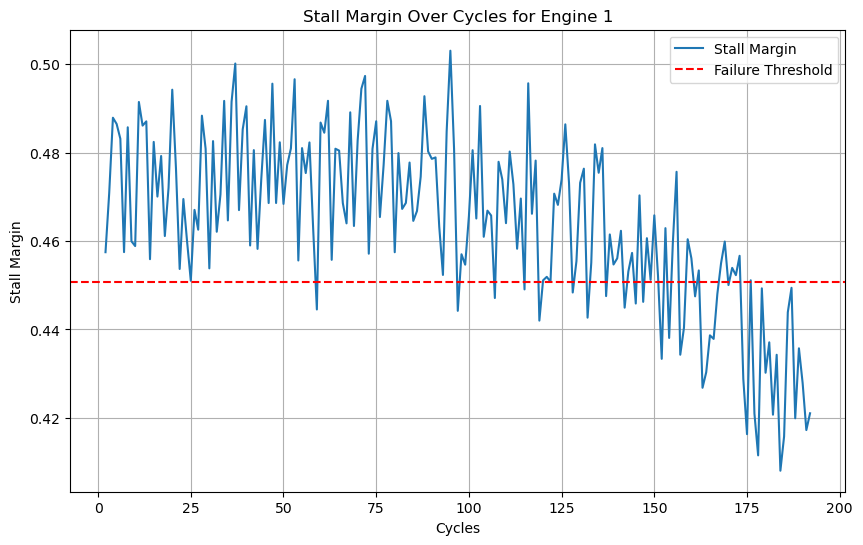

0        0.457472
1        0.470880
2        0.487878
3        0.486470
4        0.483128
5        0.457489
6        0.485713
7        0.459943
8        0.458859
9        0.491438
10       0.486093
11       0.487056
12       0.455894
13       0.482410
14       0.470050
15       0.479223
16       0.461124
17       0.472021
18       0.494214
19       0.476462
20       0.453679
21       0.469495
22       0.459876
23       0.451018
24       0.467041
25       0.462564
26       0.488340
27       0.480851
28       0.453819
29       0.482591
30       0.462096
31       0.470528
32       0.491682
33       0.464658
34       0.491507
35       0.500131
36       0.466990
37       0.485242
38       0.490466
39       0.458989
40       0.480553
41       0.458224
42       0.473899
43       0.487379
44       0.468588
45       0.495576
46       0.468594
47       0.482321
48       0.468388
49       0.477196
50       0.480946
51       0.496580
52       0.455599
53       0.481010
54       0.475369
55       0

In [194]:
engine_id = 1
engine_data = FD001_data[FD001_data['Engine'] == engine_id]

plt.figure(figsize=(10, 6))
plt.plot(engine_data['Cycles'], engine_data['stall_margin'], label='Stall Margin')
plt.axhline(stall_margin_failure_threshold, color='red', linestyle='--', label='Failure Threshold')
plt.title(f'Stall Margin Over Cycles for Engine {engine_id}')
plt.xlabel('Cycles')
plt.ylabel('Stall Margin')
plt.legend()
plt.grid(True)
plt.show()

print(stall_margin)




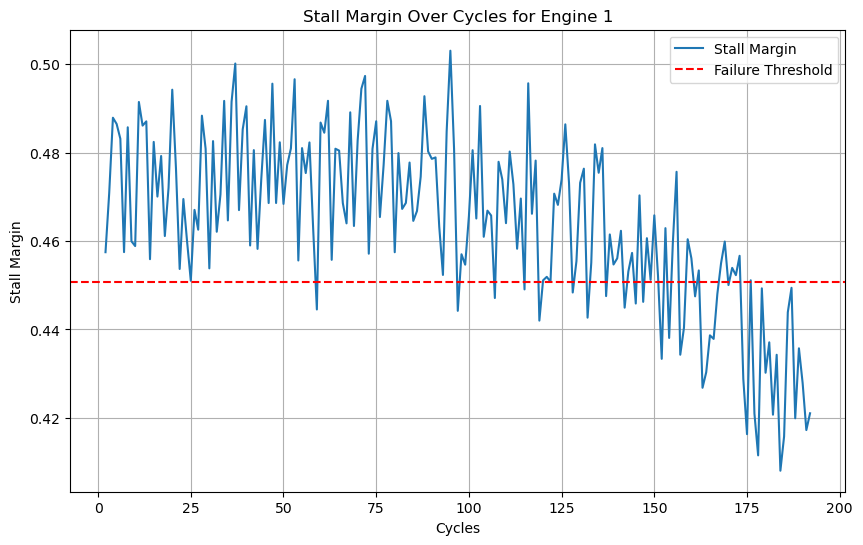

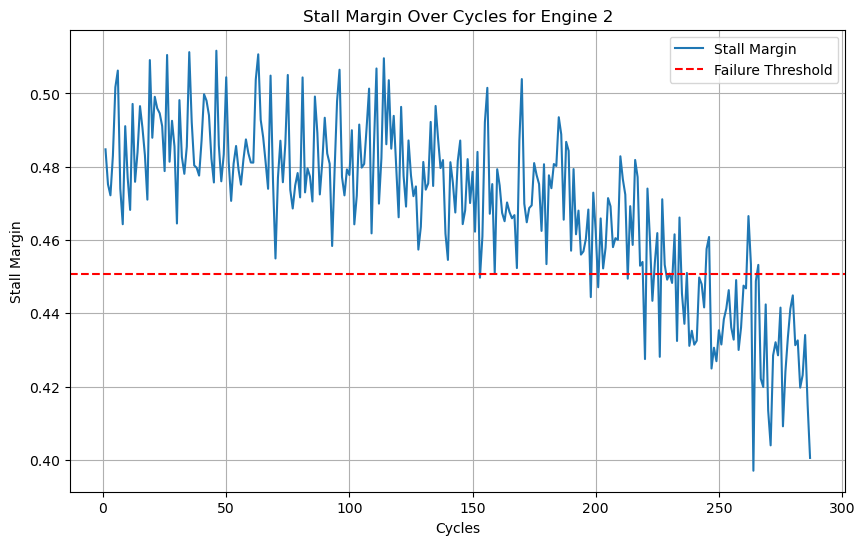

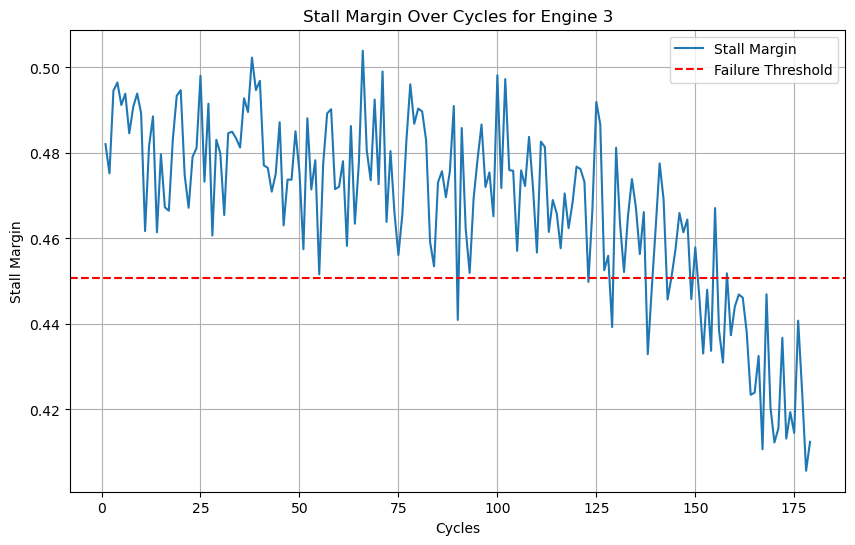

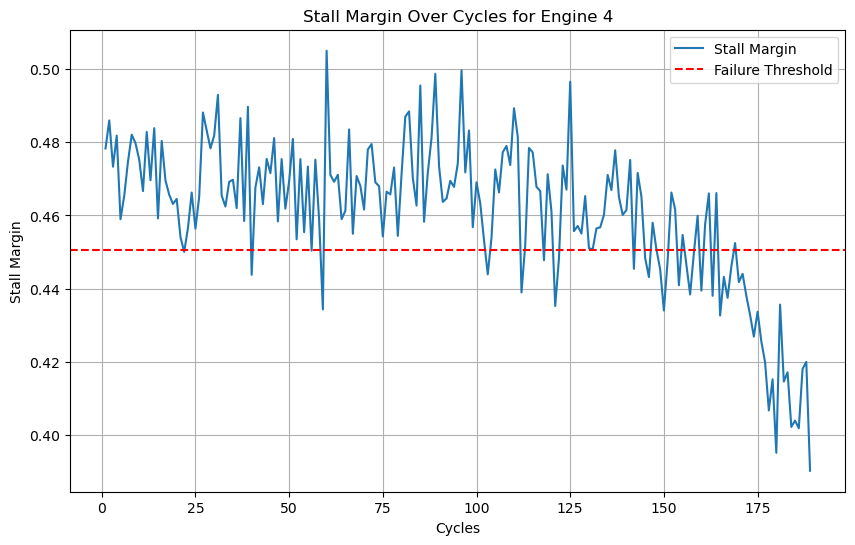

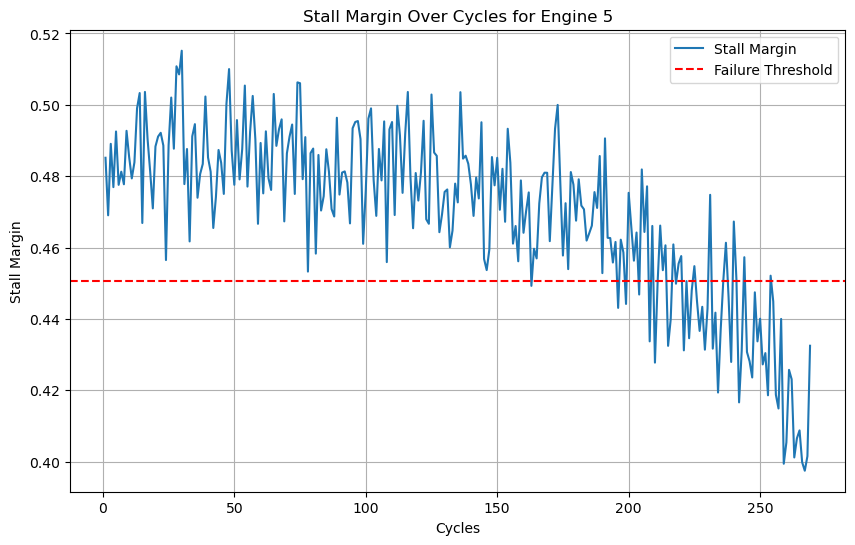

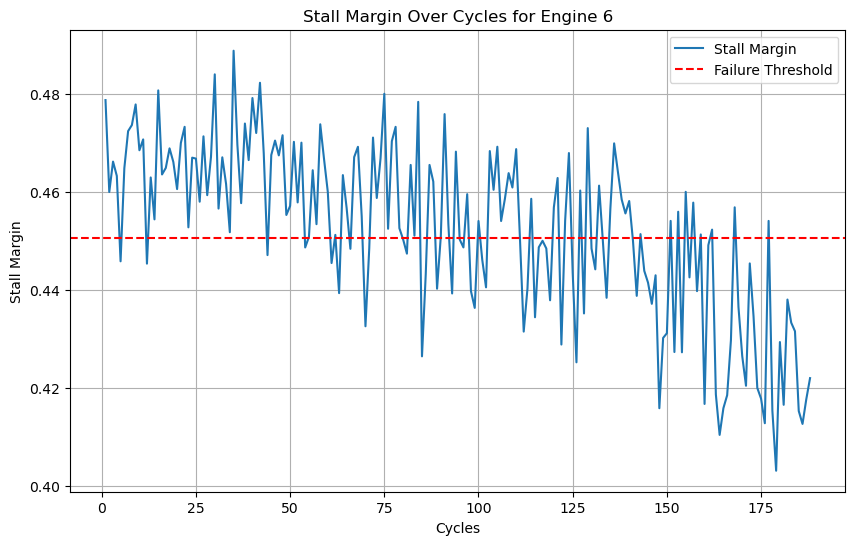

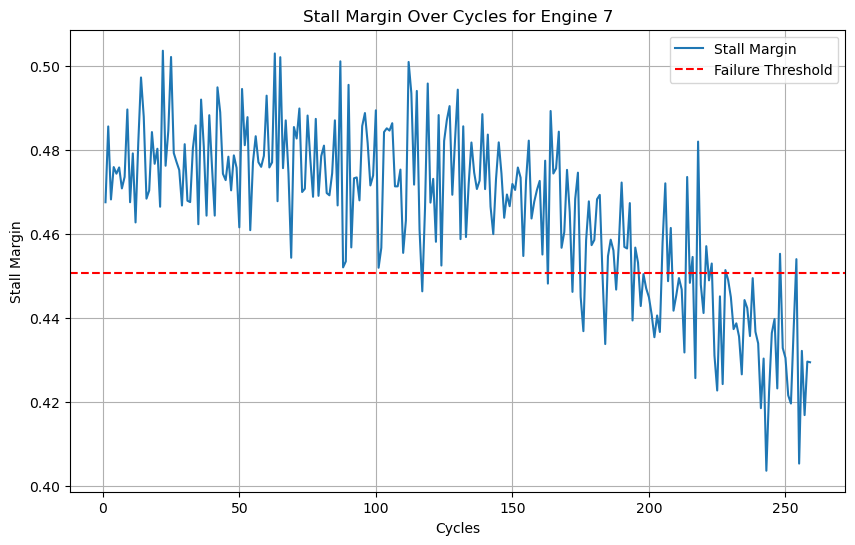

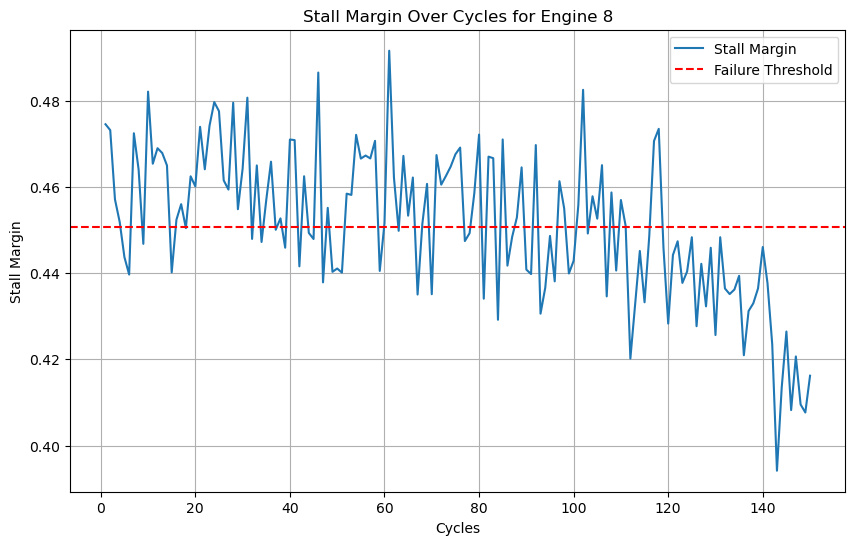

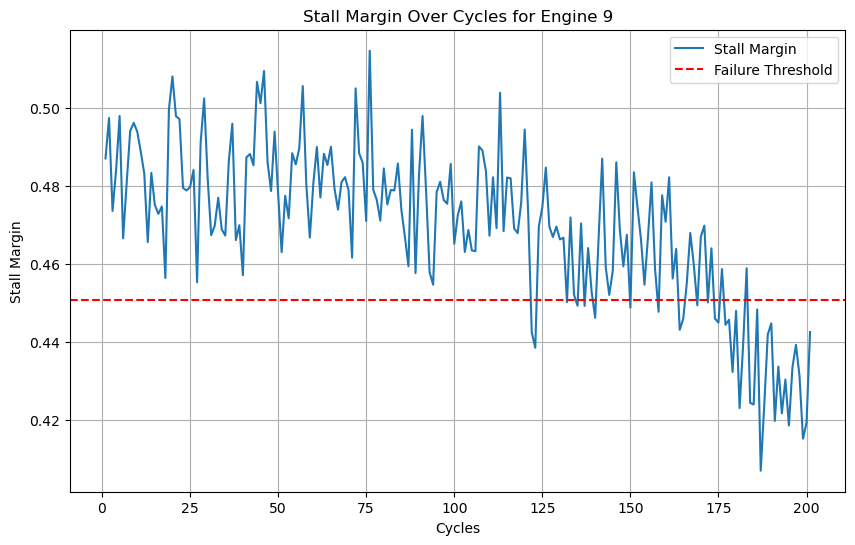

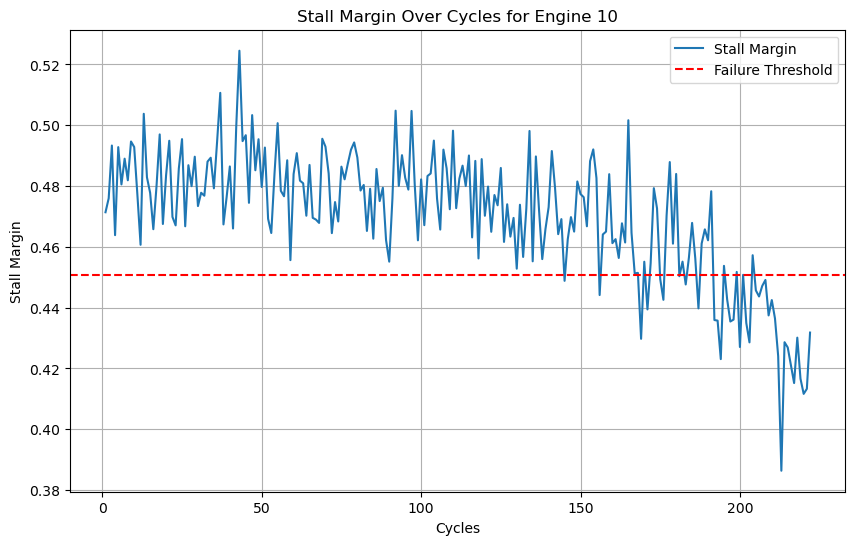

In [195]:
import matplotlib.pyplot as plt

# Function to plot stall margin over cycles for each engine
def plot_stall_margin(engine_ids, df, failure_threshold):
    for engine_id in engine_ids:
        engine_data = df[df['Engine'] == engine_id]

        plt.figure(figsize=(10, 6))
        plt.plot(engine_data['Cycles'], engine_data['stall_margin'], label='Stall Margin')
        plt.axhline(failure_threshold, color='red', linestyle='--', label='Failure Threshold')
        plt.title(f'Stall Margin Over Cycles for Engine {engine_id}')
        plt.xlabel('Cycles')
        plt.ylabel('Stall Margin')
        plt.legend()
        plt.grid(True)
        plt.show()

# Assuming 'Engine' column identifies the engine number and 'Cycles' column identifies the cycle count
engine_ids = FD001_data['Engine'].unique()[:10]  # Select the first 10 engines

# Plot stall margin for the first 10 engines
plot_stall_margin(engine_ids, FD001_data, stall_margin_failure_threshold)


In [196]:
FD001_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20630 entries, 0 to 20629
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Engine                                20630 non-null  int64  
 1   Cycles                                20630 non-null  int64  
 2   Operational Setting 1                 20630 non-null  float64
 3   Operational Setting 2                 20630 non-null  float64
 4   Operational Setting 3                 20630 non-null  float64
 5   Fan inlet temperature ◦R              20630 non-null  float64
 6   LPC outlet temperature ◦R             20630 non-null  float64
 7   HPC outlet temperature ◦R             20630 non-null  float64
 8   LPT outlet temperature ◦R             20630 non-null  float64
 9   Fan inlet Pressure psia               20630 non-null  float64
 10  bypass-duct pressure psia             20630 non-null  float64
 11  HPC outlet pres

In [231]:
X = FD001_data[['efficiency_loss', 'flow_loss']]
y = FD001_data['stall_margin']

scale = StandardScaler()
X_scale = scale.fit_transform(X)

In [232]:
lin_model = LinearRegression().fit(X_scale,y)
preds = lin_model.predict(X_scale)
absMean = mean_absolute_error(y,preds)
print(absMean)

6.643847964377057e-17


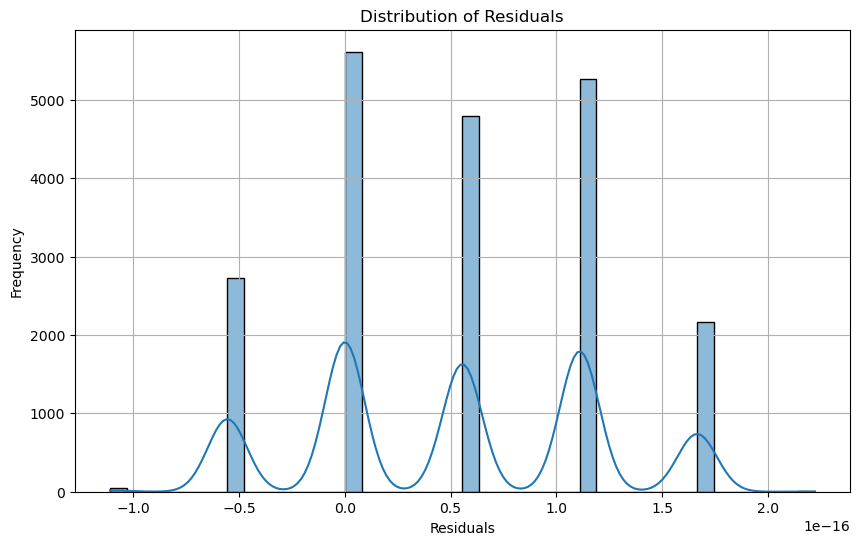

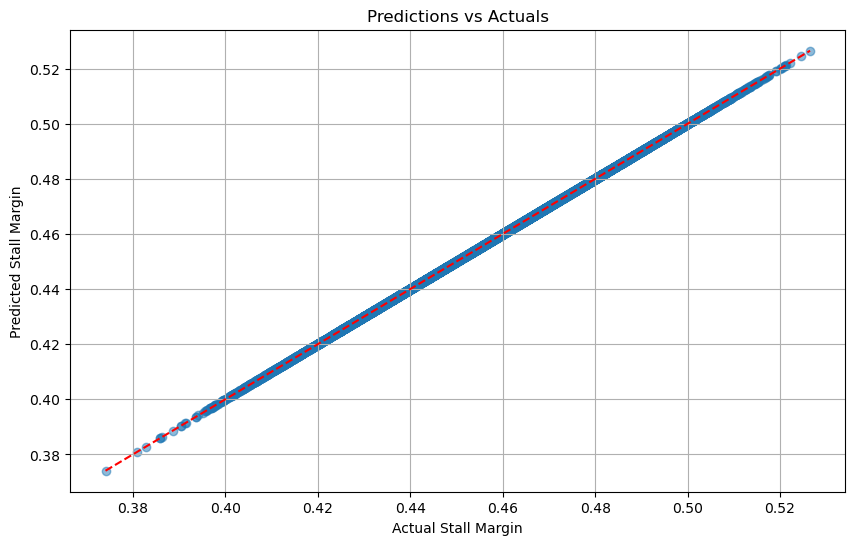

In [233]:
residuals = y - preds

# Plotting Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plotting Predictions vs. Actuals
plt.figure(figsize=(10, 6))
plt.scatter(y, preds, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red')  # Identity line
plt.title('Predictions vs Actuals')
plt.xlabel('Actual Stall Margin')
plt.ylabel('Predicted Stall Margin')
plt.grid(True)
plt.show()

In [208]:
X = FD001_data
scale = StandardScaler()
X_scale = scale.fit_transform(X)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scale)


In [216]:
# Perform KMeans clustering
optimal_clusters = 3  # Based on the elbow method
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(X_pca)


0.8301502666020358 2 0.7367786500469323


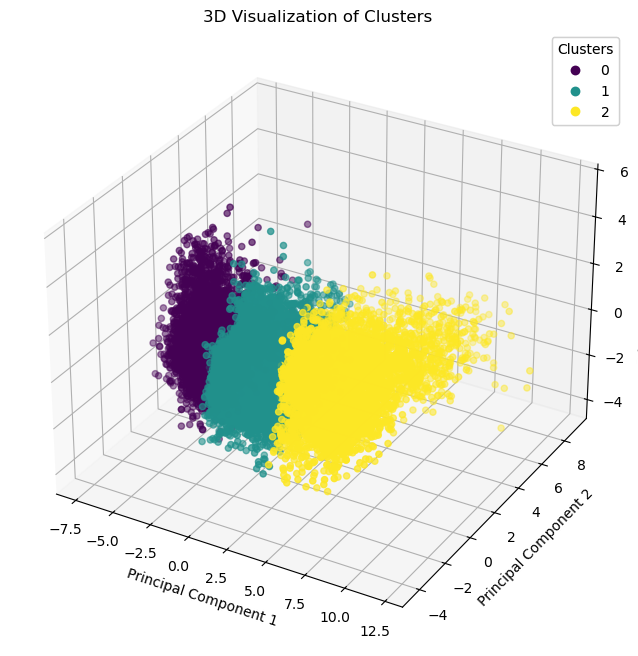

In [217]:
# 3D scatter plot of the clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=clusters, cmap='viridis', marker='o')

# Adding title and labels
ax.set_title('3D Visualization of Clusters')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Adding color bar to indicate cluster labels
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

In [218]:
import plotly.graph_objs as go

fig = go.Figure()

# Add trace for each cluster
for i in range(optimal_clusters):
    fig.add_trace(go.Scatter3d(
        x=X_pca[clusters == i, 0],
        y=X_pca[clusters == i, 1],
        z=X_pca[clusters == i, 2],
        mode='markers',
        marker=dict(size=5),
        name=f'Cluster {i}'
    ))

# Update layout for better visualization
fig.update_layout(
    scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3'
    ),
    title='Interactive 3D Visualization of Clusters'
)

# Show the figure
fig.show()